# Heat transfer problem

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from numba import njit, prange
from scipy.signal import find_peaks
import time

Situation: 0
Time spent: 2.9371 s


<Figure size 432x288 with 0 Axes>

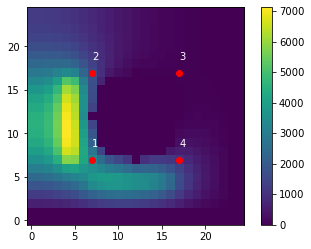

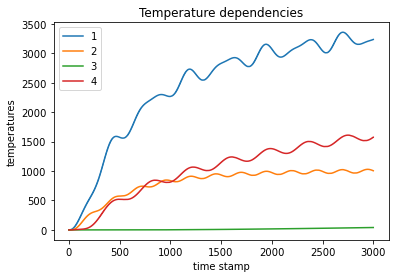

In probe 1 we've got period [66.68888889 50.01666667]
In probe 2 we've got period [50.01666667]
In probe 3 we've got period []
In probe 4 we've got period [66.68888889]
Situation: 1
Time spent: 5.3601 s


<Figure size 432x288 with 0 Axes>

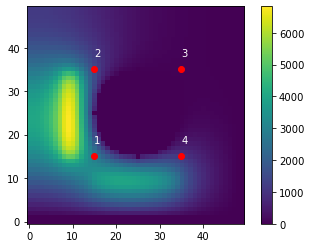

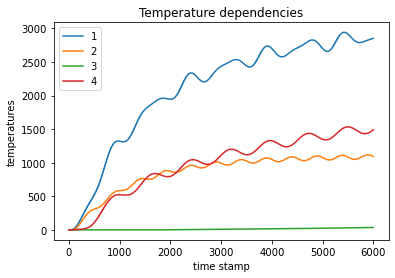

In probe 1 we've got period [66.67777778 50.00833333]
In probe 2 we've got period [50.00833333]
In probe 3 we've got period []
In probe 4 we've got period [66.67777778]
Situation: 2
Time spent: 37.4875 s


<Figure size 432x288 with 0 Axes>

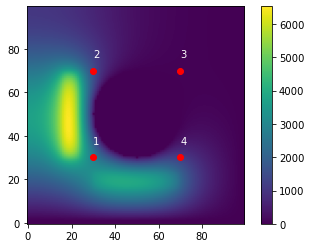

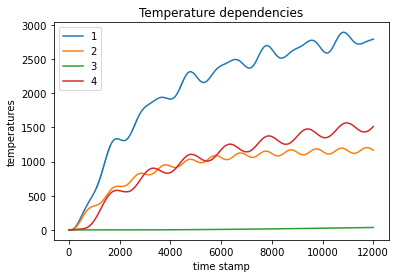

In probe 1 we've got period [66.67222222 50.00416667]
In probe 2 we've got period [50.00416667]
In probe 3 we've got period []
In probe 4 we've got period [66.67222222]
Situation: 3
Time spent: 436.6194 s


<Figure size 432x288 with 0 Axes>

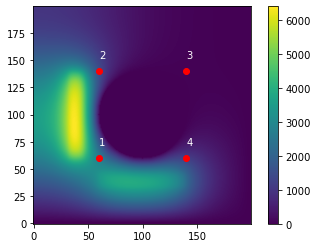

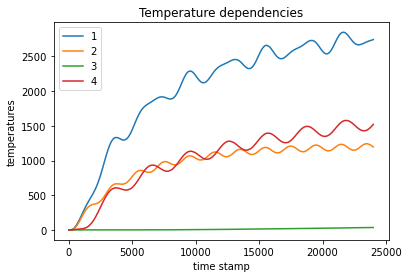

In probe 1 we've got period [66.66944444 50.00208333]
In probe 2 we've got period [50.00208333]
In probe 3 we've got period []
In probe 4 we've got period [66.66944444]
Situation: 4
Time spent: 3547.1004 s


<Figure size 432x288 with 0 Axes>

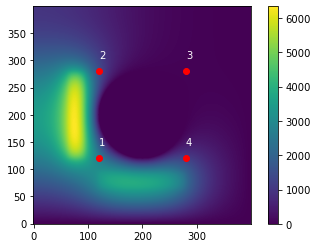

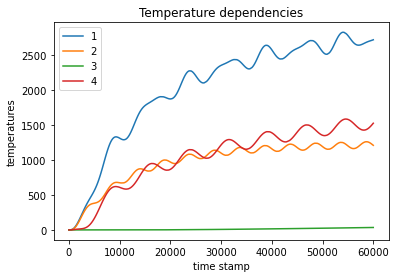

In probe 1 we've got period [66.66777778 50.00083333]
In probe 2 we've got period [50.00083333]
In probe 3 we've got period []
In probe 4 we've got period [66.66777778]


In [2]:
L = 100
D_cube = 1
D_ball = 1e-16
total_time = 600
dx_dt = [(4, 0.2), (2, 0.1), (1, 0.05), (0.5, 0.025), (0.25, 0.01)]
text = ["1", "2", "3", "4"]

def fill_cube(arr_size, center, r):
    global D_ball
    coords = np.ogrid[:arr_size[0], :arr_size[1], :arr_size[2]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2 + (coords[2]-center[2])**2) 
    return D_ball*(distance <= r)

@njit(parallel = True)
def diffuse_step_numpy(T, dt, ti, cube, steps, dx):
    ti = ti % 2
    tj = (ti + 1) % 2
    
    for i in prange(1, steps - 1):
        for j in range(1, steps - 1):
            for k in range(1, steps - 1):
                c = dt * cube[i, j, k] / dx**2
                T[tj, i, j, k] = T[ti, i, j, k] + \
                                        c * (T[ti, i+1, j, k] +
                                        T[ti, i-1, j, k] + 
                                        T[ti, i, j+1, k] + 
                                        T[ti, i, j-1, k] +
                                        T[ti, i, j, k+1] +
                                        T[ti, i, j, k-1] - 
                                        6 * T[ti, i, j, k])
                
    return T

def isolation(T):
    T[:, 0, :, :], T[:, 1, :, :] = 0, 0
    T[:, :, -1, :], T[:, :, -2, :] = 0, 0

    T[:, -1, :, :] = T[:, -2, :, :]
    T[:, :, 0, :] = T[:, :, 1, :]
    T[:, :, :, 0] = T[:, :, :, 1]
    T[:, :, :, -1] = T[:, :, :, -2]
    
    return T

def source(T, dt, it, coeff):
    T[:, mesh_1[0][0]:mesh_1[0][1], mesh_1[1][0]:mesh_1[1][1], mesh_1[2][0]:mesh_1[2][1]] += dt * coeff[0][0] * (math.sin(2*np.pi * dt * it / coeff[0][1] + coeff[0][2]) + 1)
    T[:, mesh_2[0][0]:mesh_2[0][1], mesh_2[1][0]:mesh_2[1][1], mesh_2[2][0]:mesh_2[2][1]] += dt * coeff[1][0] * (math.sin(2*np.pi * dt * it / coeff[1][1] + coeff[1][2]) + 1)
    
    return T
    
for i, (dx, dt) in enumerate(dx_dt):
    print(f"Situation: {i}")
    
    steps = L // dx
    
    cube_size = (steps, steps, steps)
    sphere_center = (steps // 2, steps // 2, steps // 2)
    R = L / 5 / dx
    cube = fill_cube(cube_size, sphere_center, R)
    cube = cube.flatten()
    cube[cube==0] = D_cube
    cube = cube.reshape((int(L // dx), int(L // dx), int(L // dx)))
    
    T = np.zeros((2, int(steps), int(steps), int(steps)), dtype=float)
    
    pos = np.array([[(0.2 * L) // dx, (0.5 * L) // dx, (0.5 * L) // dx], [(0.5 * L) // dx, (0.2 * L) // dx, (0.5 * L) // dx]], dtype=int)
    size = np.array([[4 // dx, (0.2 * L) // dx, (0.2 * L) // dx], [(0.2 * L) // dx, 4 // dx, (0.2 * L) // dx]], dtype=int)
    coeff = np.array([[100, 50, 0], [100, 77, 10]], dtype=int)
    mesh_1 = np.array([[pos[0][0] - size[0][0], pos[0][0] + size[0][0]], [pos[0][1] - size[0][1], pos[0][1] + size[0][1]], [pos[0][2] - size[0][2], pos[0][2] + size[0][2]]], dtype=int)
    mesh_2 = np.array([[pos[1][0] - size[1][0], pos[1][0] + size[1][0]], [pos[1][1] - size[1][1], pos[1][1] + size[1][1]], [pos[1][2] - size[1][2], pos[1][2] + size[1][2]]], dtype=int)
    probes = np.array([[(0.3 * L) // dx, (0.3 * L) // dx, (0.5 * L) // dx], [(0.3 * L) // dx, (0.7 * L) // dx, (0.5 * L) // dx], [(0.7 * L) // dx, (0.7 * L) // dx, (0.5 * L) // dx], [(0.7 * L) // dx, (0.3 * L) // dx, (0.5 * L) // dx]], dtype=np.int64)
    temperature = [[], [], [], []]
    
    start = time.time()
    it = 0
    while dt*it <= total_time:
        T = source(T, dt, it, coeff)
        T = diffuse_step_numpy(T, dt, it, cube, int(steps), dx)
        T = isolation(T)
        temperature[0].append(T[0, probes[0][0], probes[0][1], probes[0][2]])
        temperature[1].append(T[0, probes[1][0], probes[1][1], probes[1][2]])
        temperature[2].append(T[0, probes[2][0], probes[2][1], probes[2][2]])
        temperature[3].append(T[0, probes[3][0], probes[3][1], probes[3][2]])
        it += 1
        
    print(f"Time spent: {round(time.time() - start, 4)} s")
        
    with open('heatmap_num_{}.npy'.format(i), 'wb') as f:
        np.save(f, T)
        
    for j in range(len(probes)):
        with open('temperature_dx_{}_dt_{}_probe_{}.npy'.format(dx, dt, j), 'wb') as f:
            np.save(f, np.array(temperature[j]))
        
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    with open('heatmap_num_{}.npy'.format(i), 'rb') as f:
        T_loaded = np.load(f)
    img = ax.imshow(T_loaded[0, :, :, int((0.5 * L) // dx)].squeeze())
    ax.scatter([probes[0][0], probes[1][0], probes[2][0], probes[3][0]], [probes[0][1], probes[1][1], probes[2][1], probes[3][1]], marker='o', c='r')
    for j in range(len(probes)):
        ax.annotate(text[j], (probes[j][0], probes[j][1] + steps * 0.06), c='w')
    fig.colorbar(img)
    ax.invert_yaxis()
    plt.show()
    
    temperature_loaded = []
            
    for j in range(len(probes)):
        with open('temperature_dx_{}_dt_{}_probe_{}.npy'.format(dx, dt, j), 'rb') as f:
            temperature_loaded.append(np.load(f))
            
    temperature_loaded = np.array(temperature_loaded)
    plt.clf()
    plt.plot(temperature_loaded.T)
        
    plt.legend(text)
    plt.title('Temperature dependencies')
    plt.ylabel('temperatures')
    plt.xlabel('time stamp')
    plt.show()
    
    for j in range(len(probes)):
        r = np.fft.rfft(temperature_loaded[j])
        amp = np.abs(r) / (it / 2)
        freq = np.fft.rfftfreq(it, dt)
        idx, h = find_peaks(amp, height=10)
        print(f'In probe {j+1} we\'ve got period {1 / freq[idx]}')